2024-04-11 18:30:10.407466: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 18:30:10.456698: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-11 18:30:10.541532: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 18:30:12.477250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Classification Accuracies:
Hidden Nodes    Learning Rate   Train Accuracy(%) Validation Accuracy(%) Test Accuracy(%)
10              0.01            100.00          100.00              100.00         
10              0.1             100.00          100.00              100.00         
10              0.5             100.00          100.00              100.00         
20              0.01            100.00          100.00              100.00         
20              0.1             100.00          100.00              100.00         
20              0.5             100.00          100.00              100.00         
30              0.01            100.00          100.00              100.00         
30              0.1             100.00          100.00              100.00         
30              0.5             100.00          100.00              100.00         


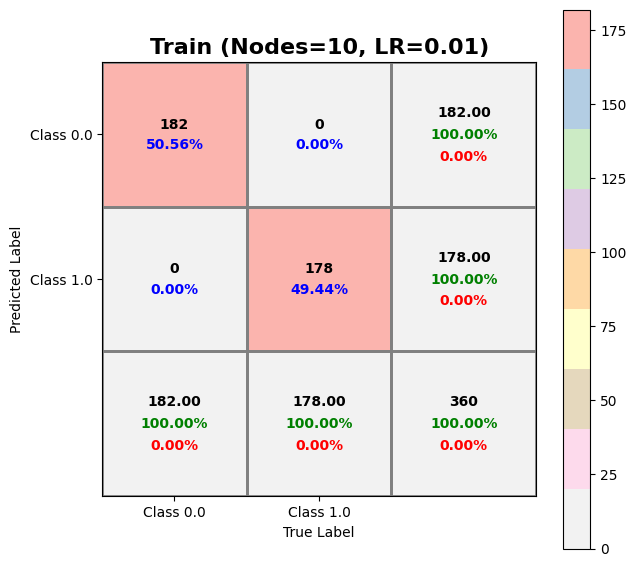

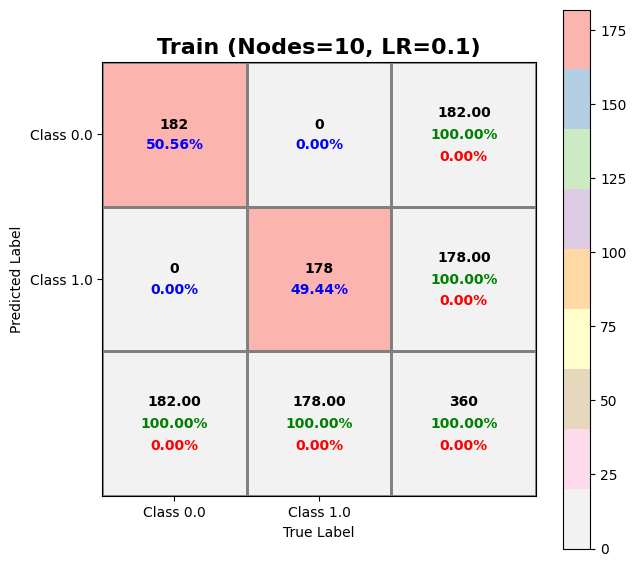

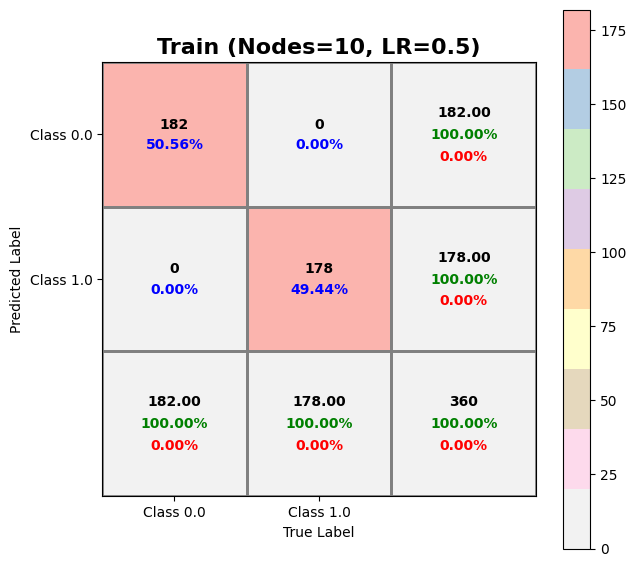

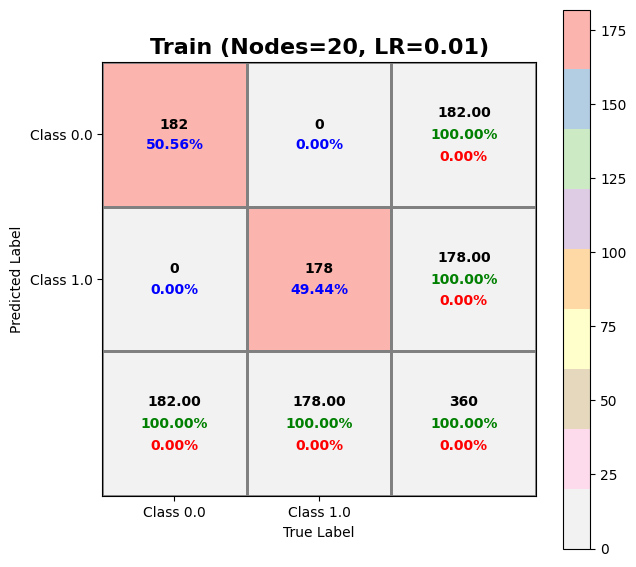

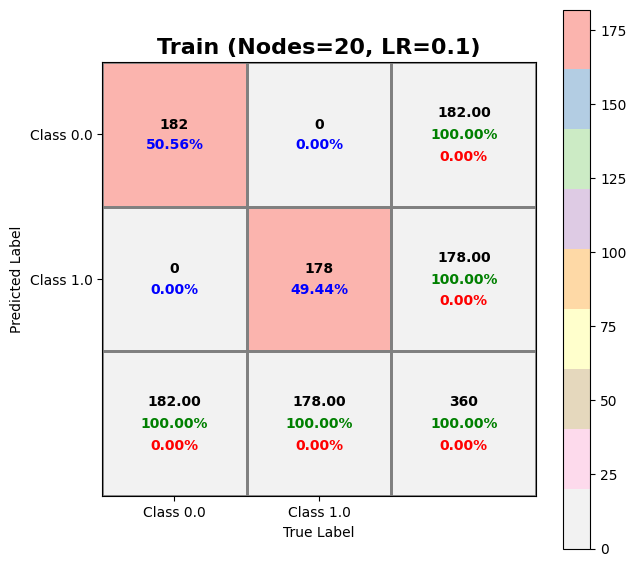

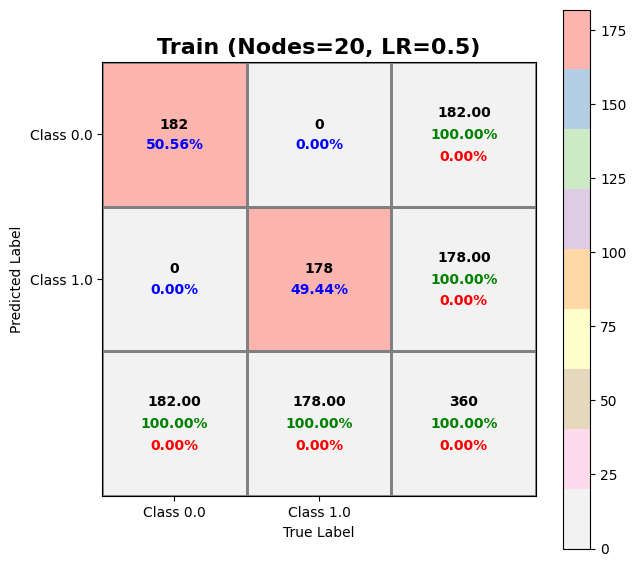

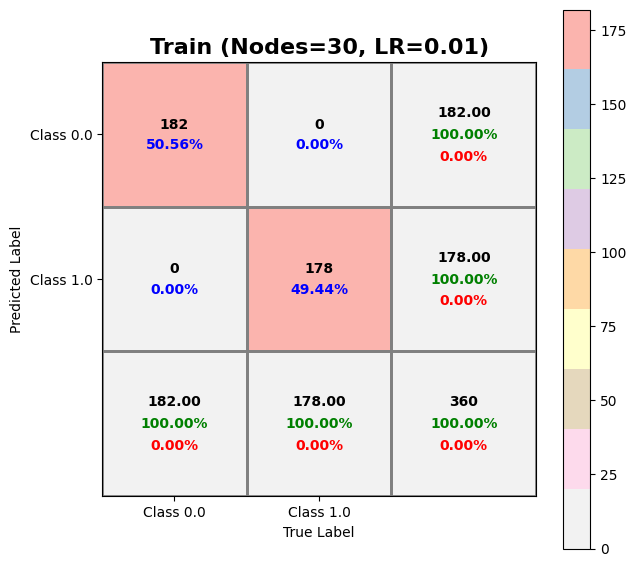

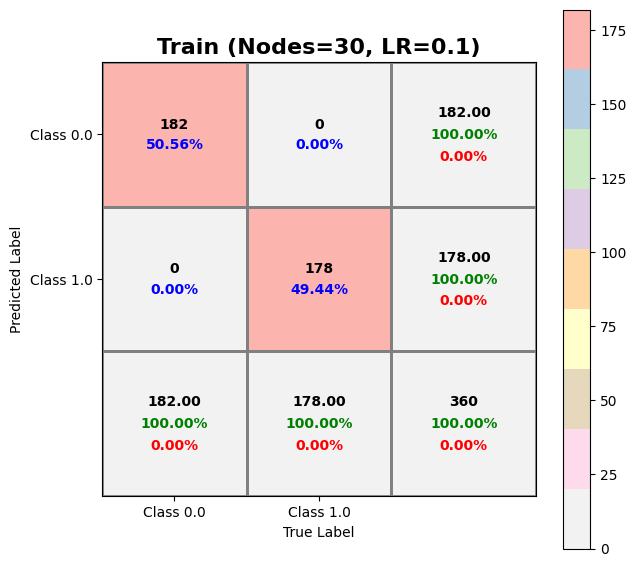

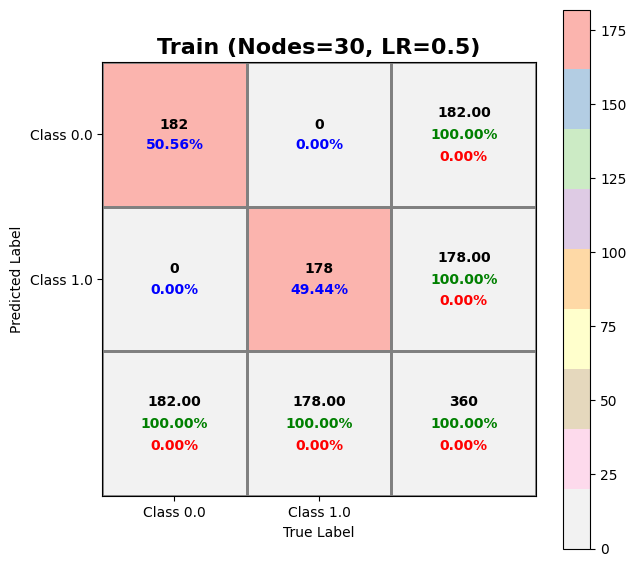

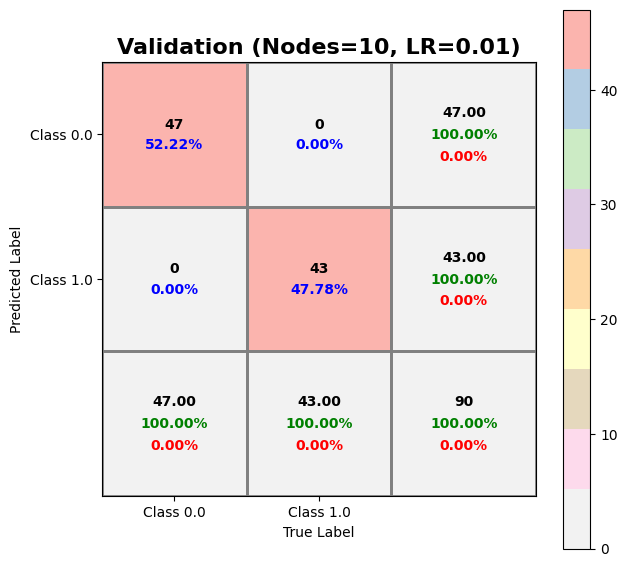

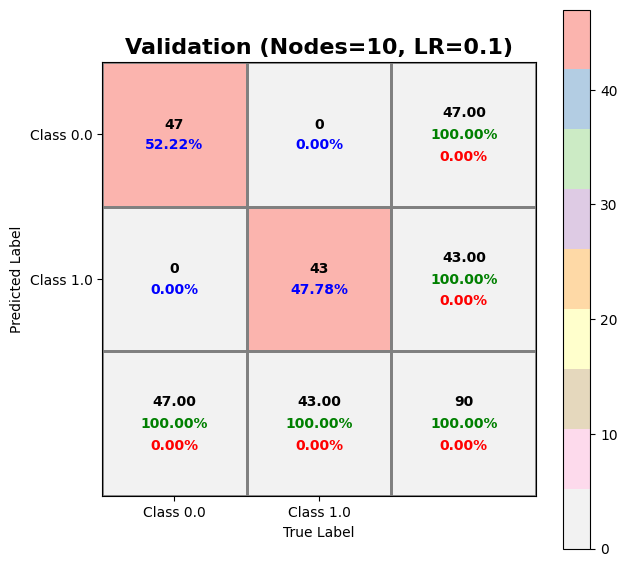

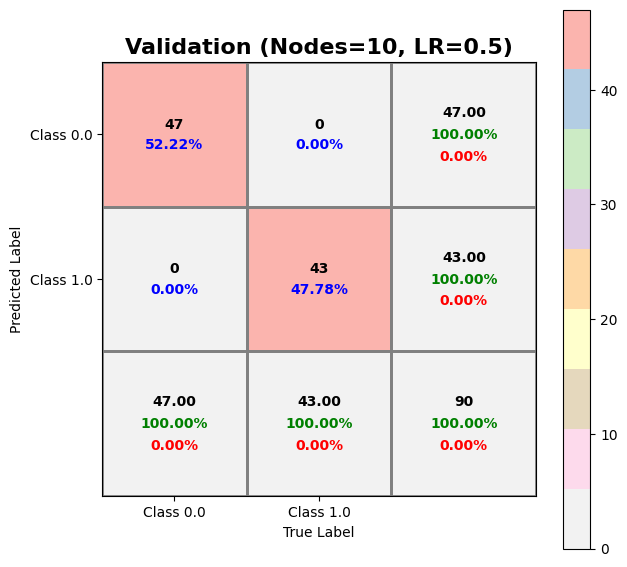

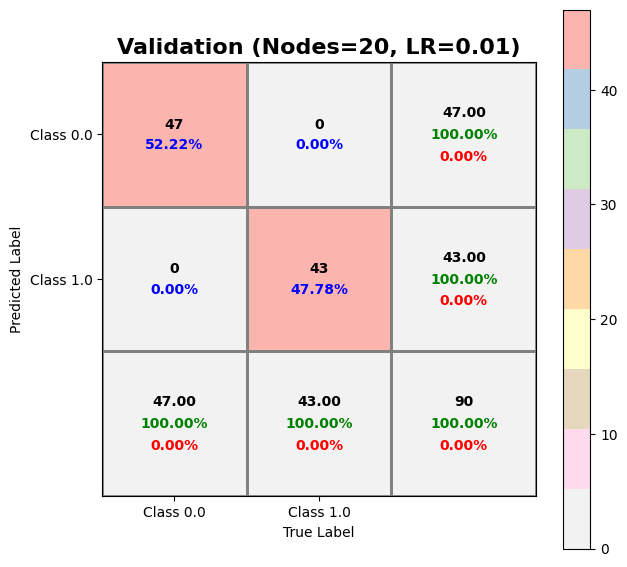

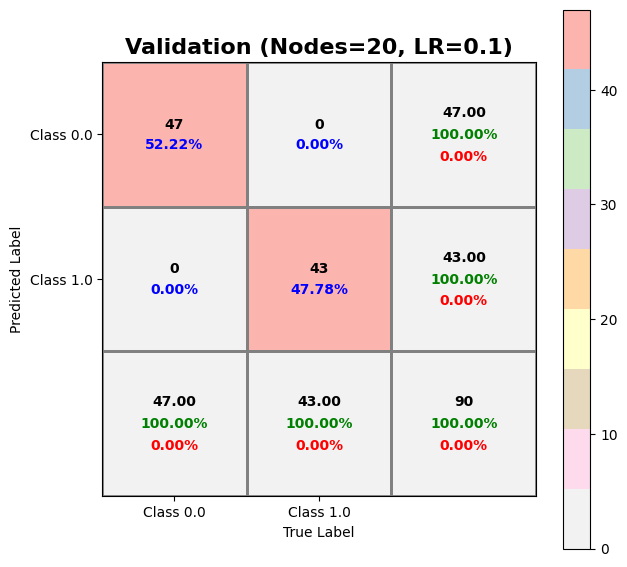

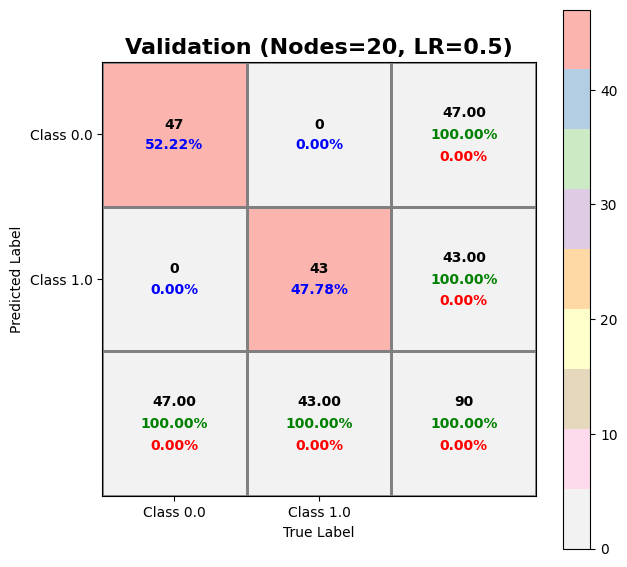

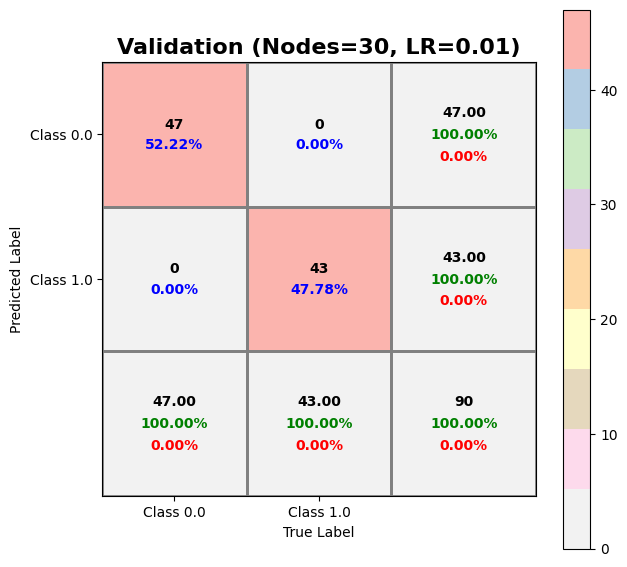

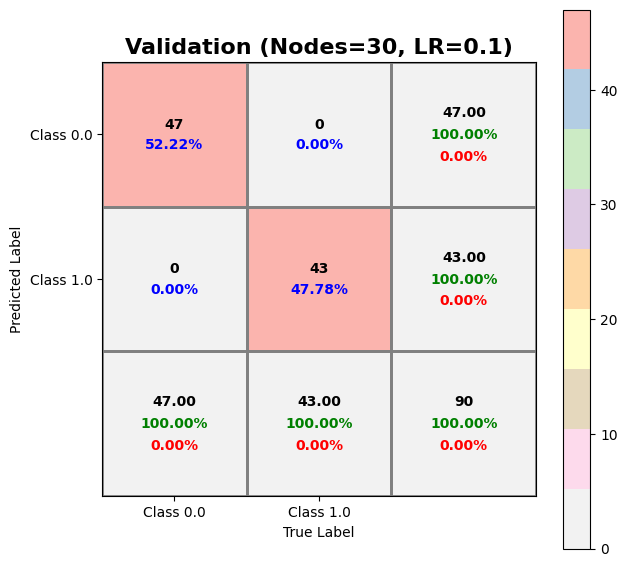

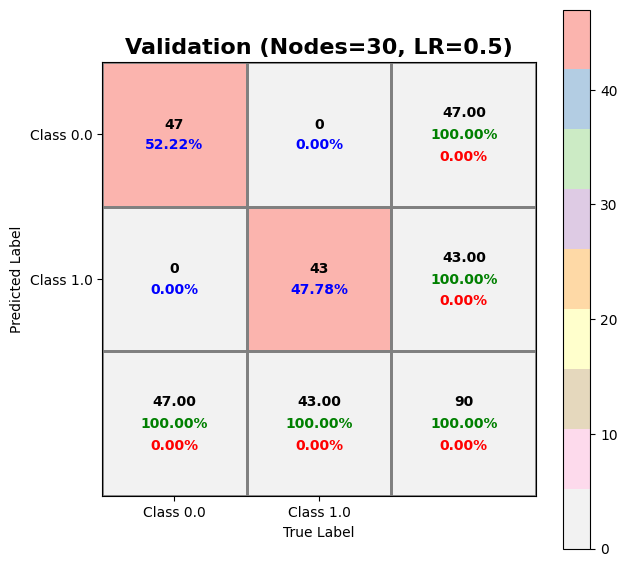

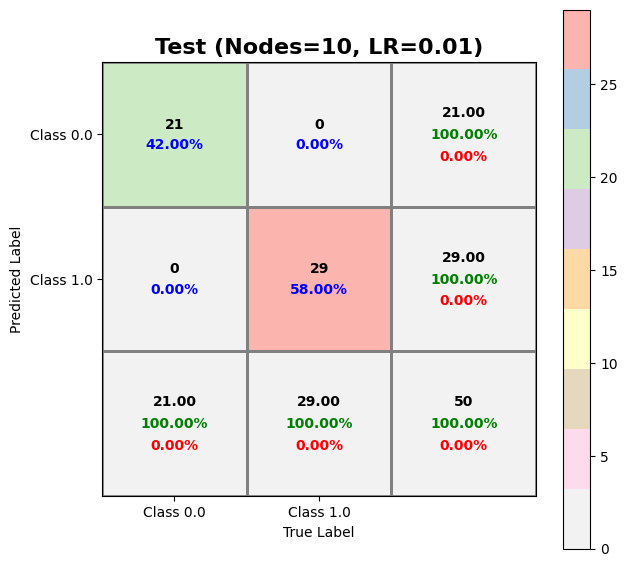

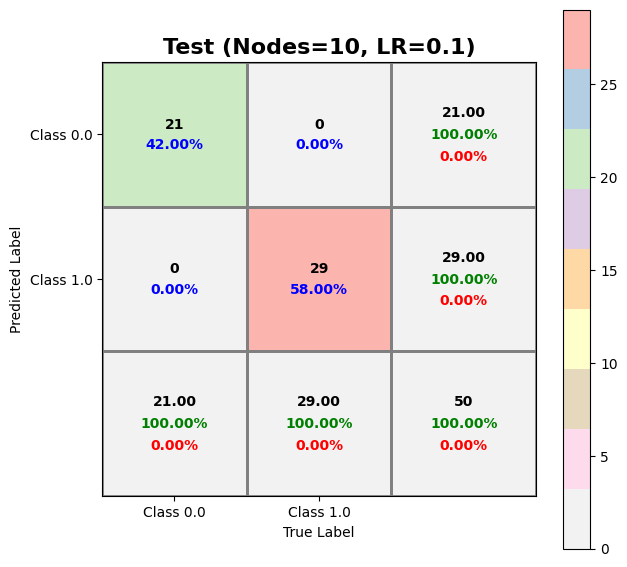

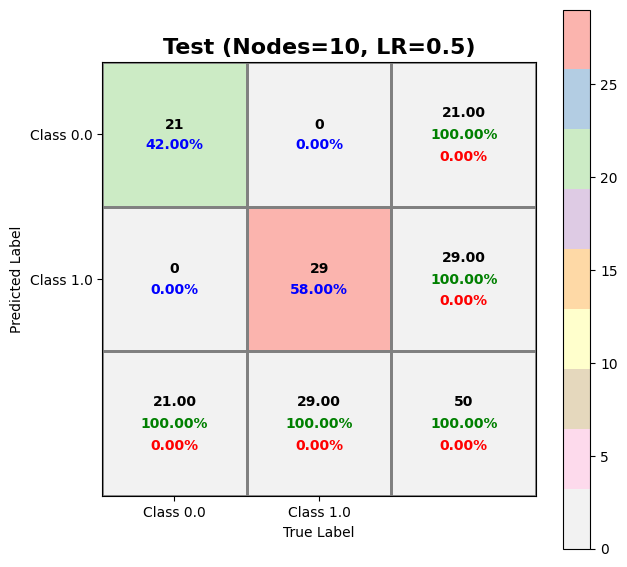

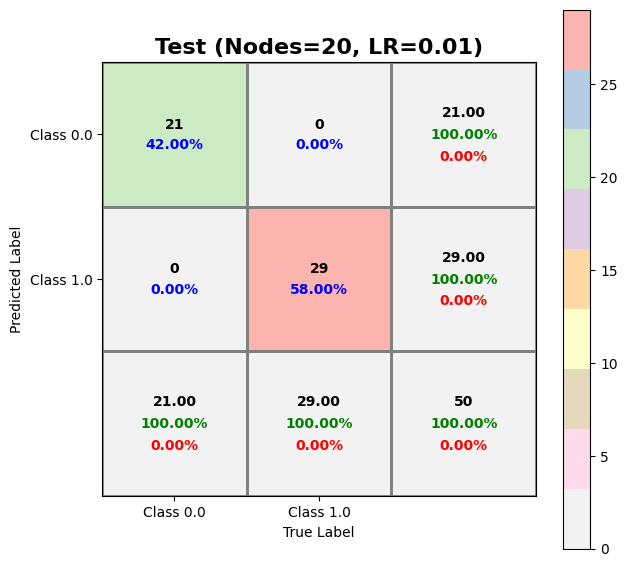

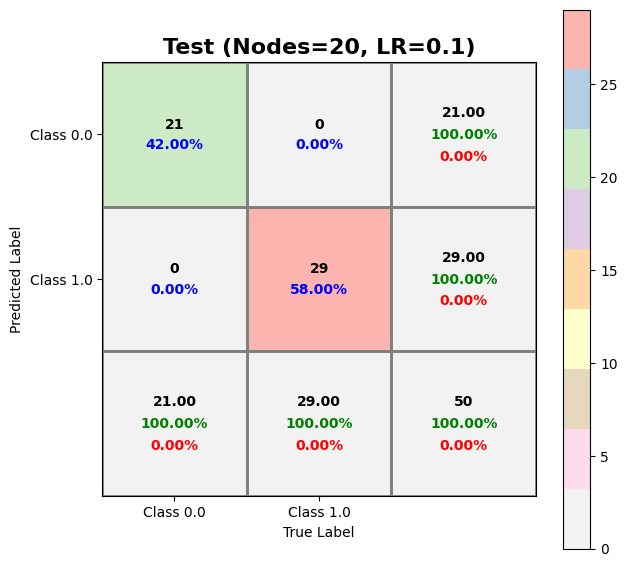

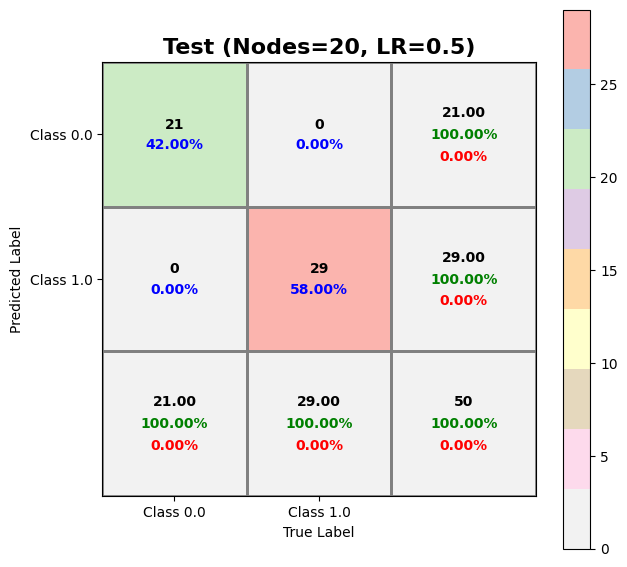

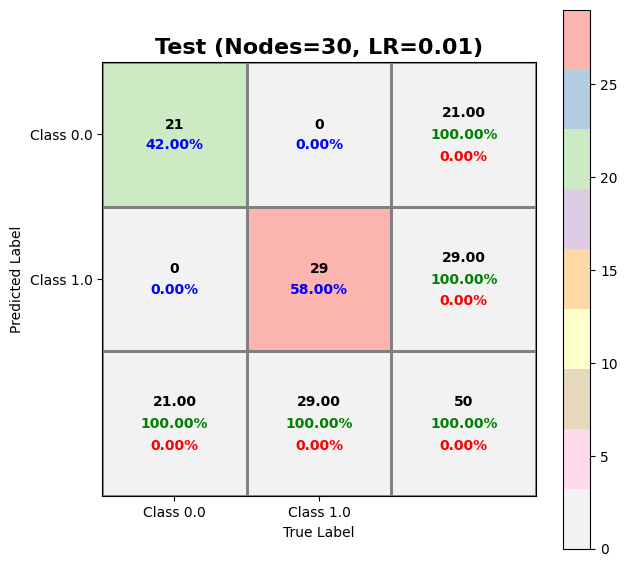

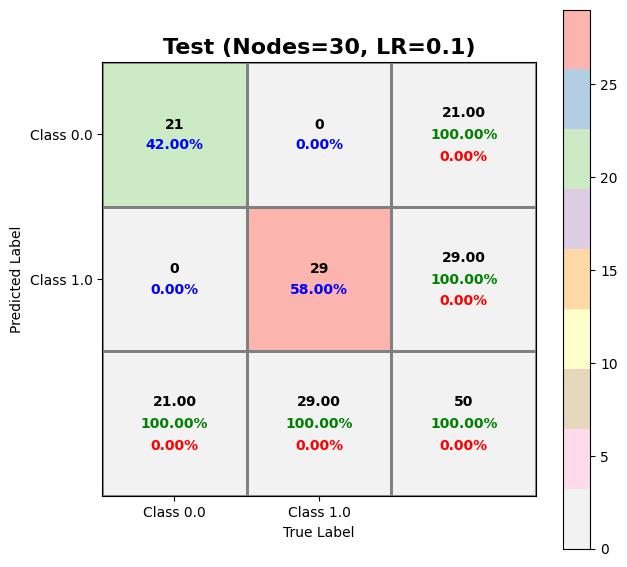

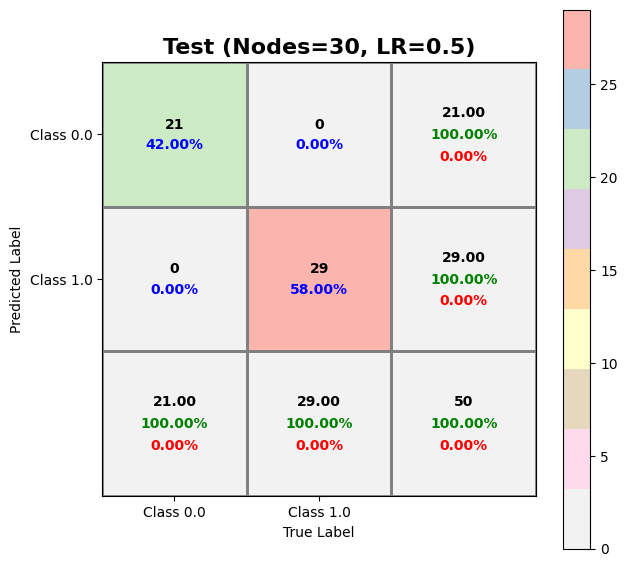

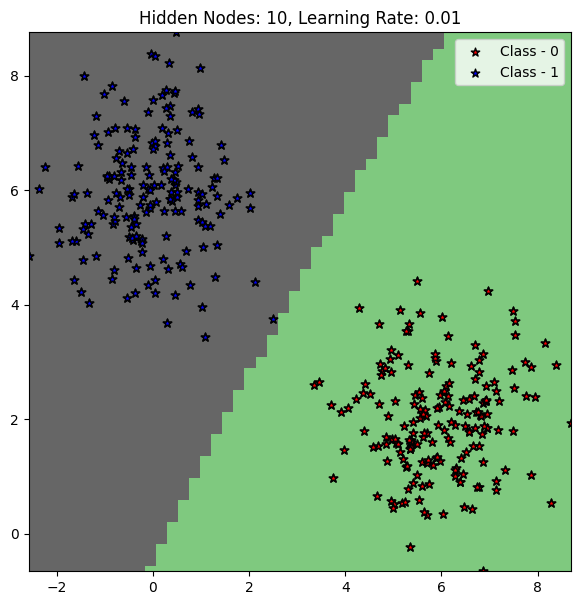

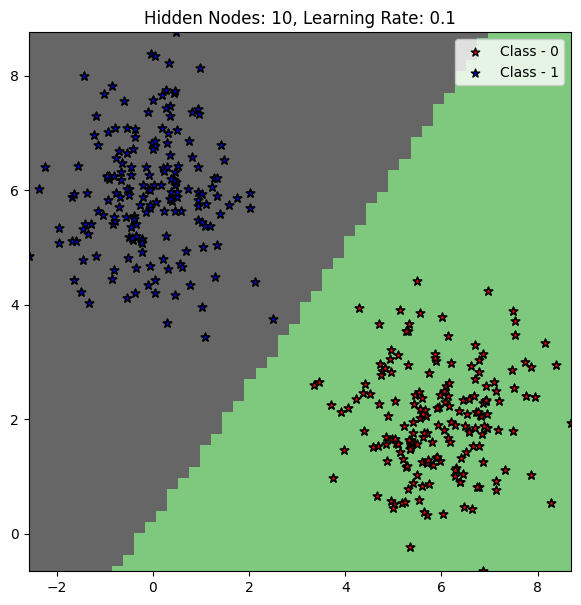

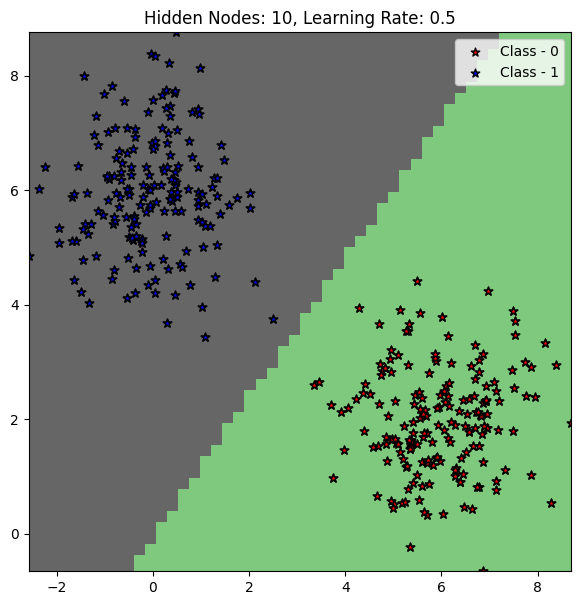

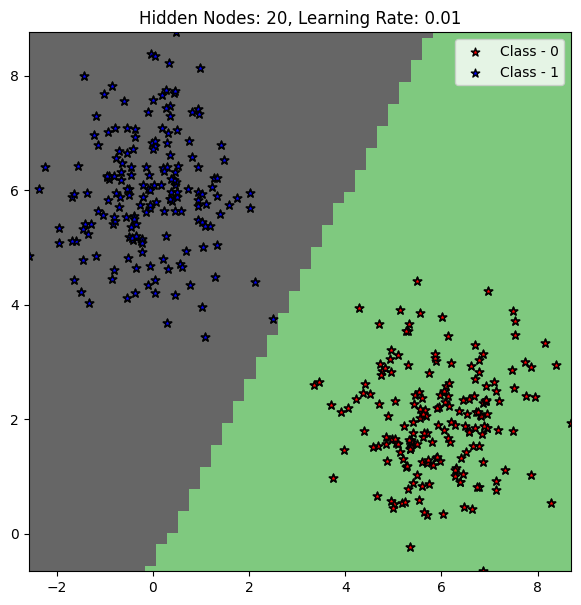

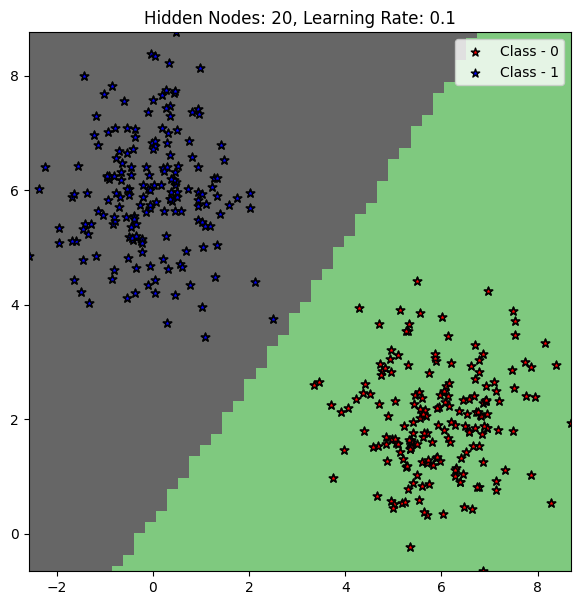

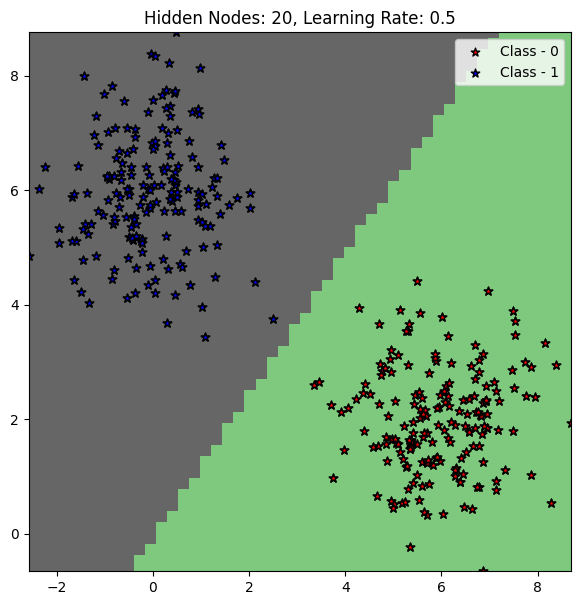

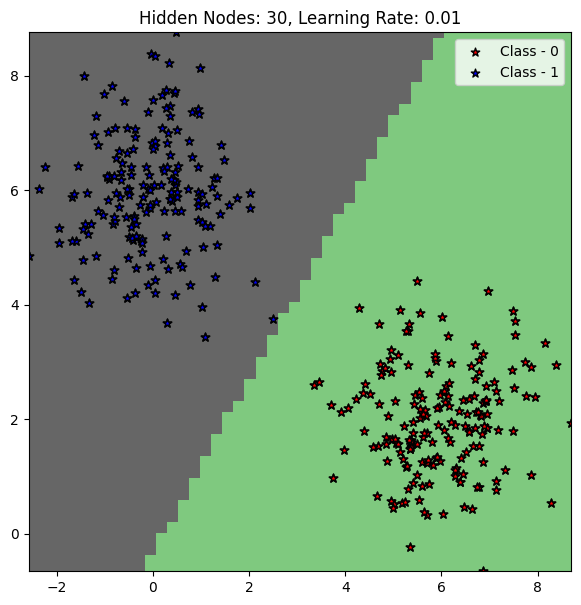

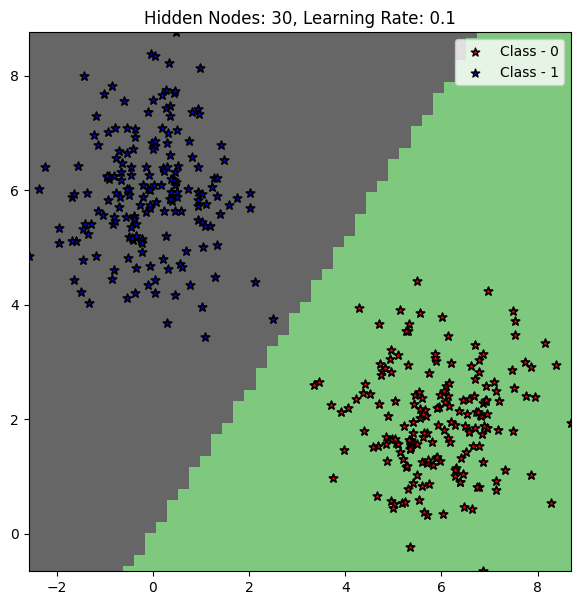

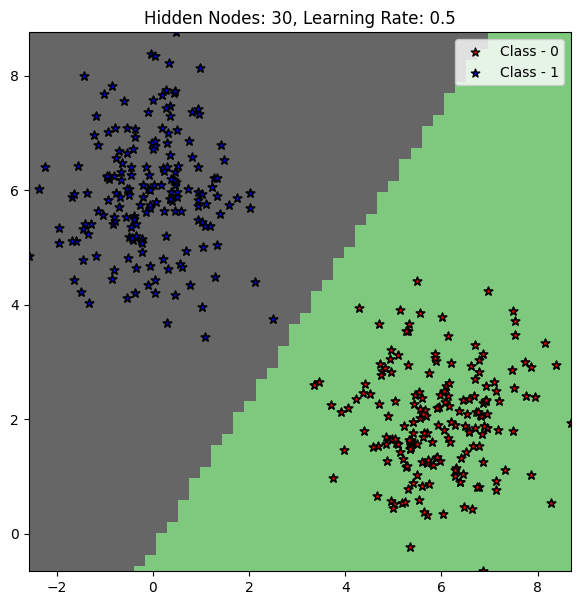

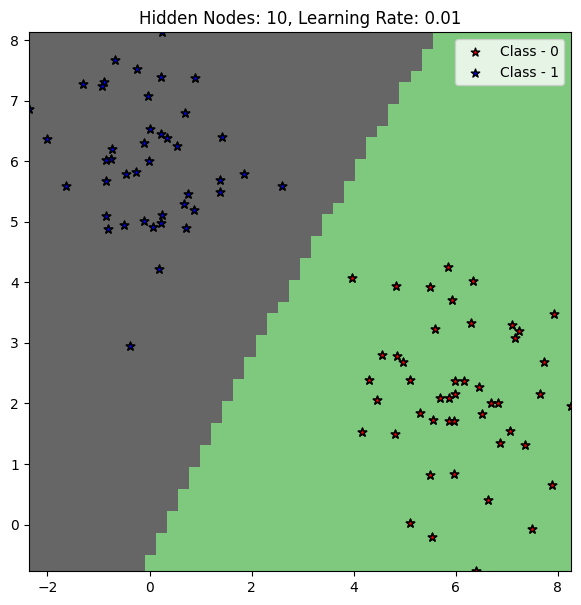

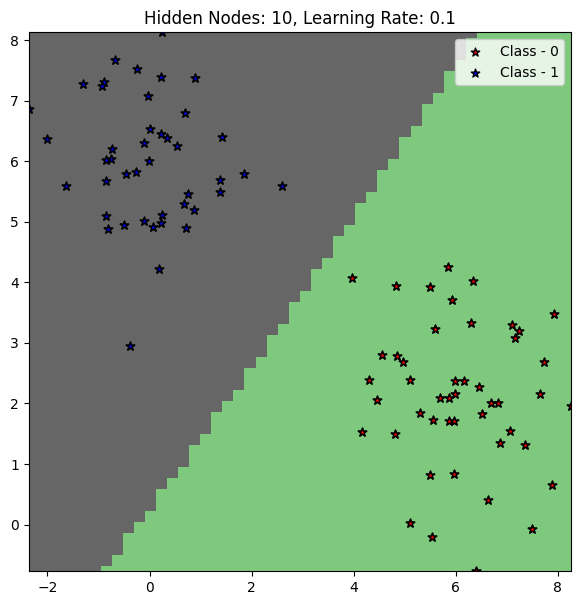

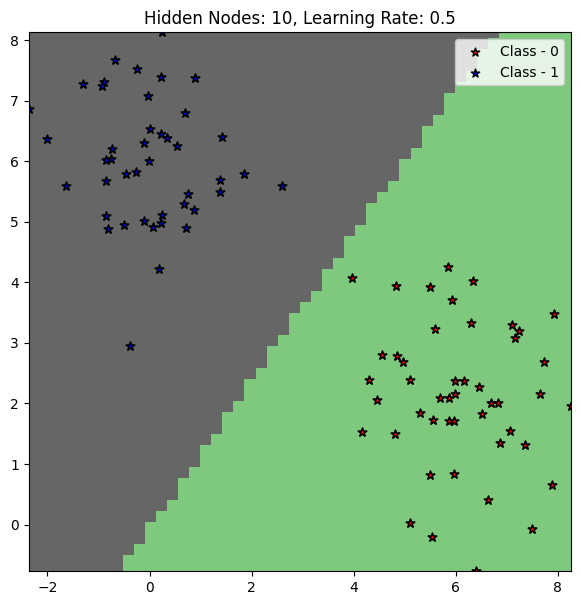

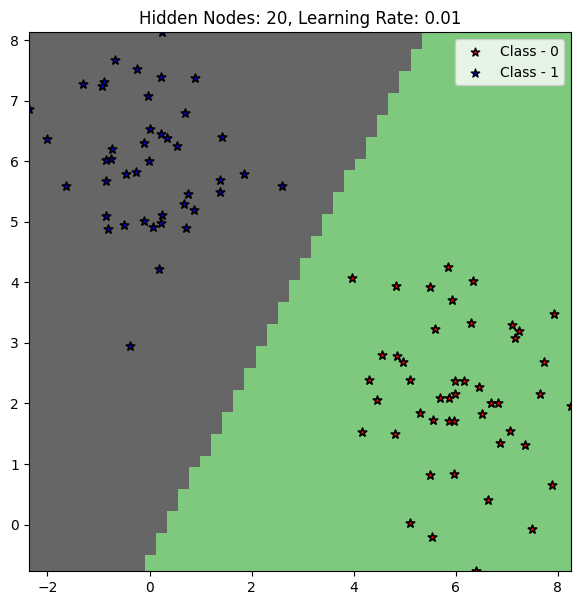

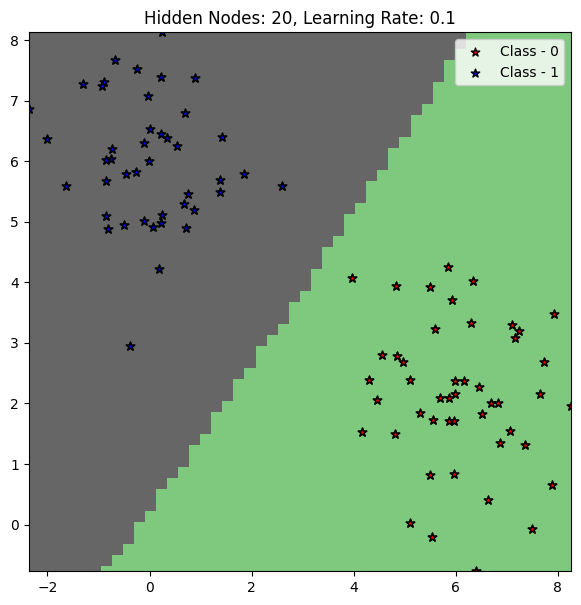

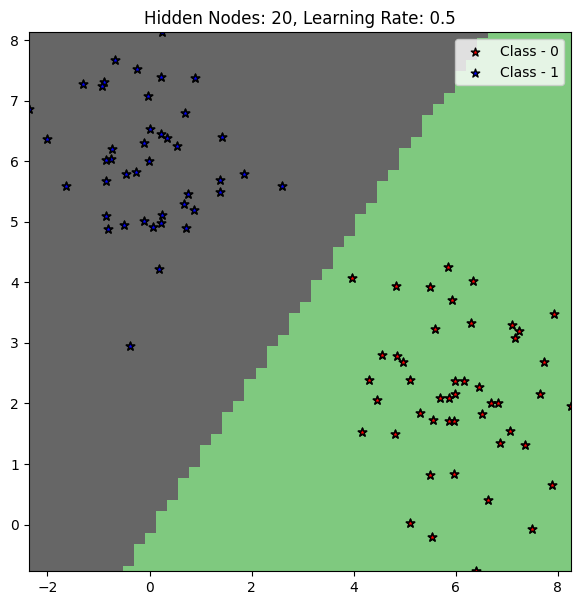

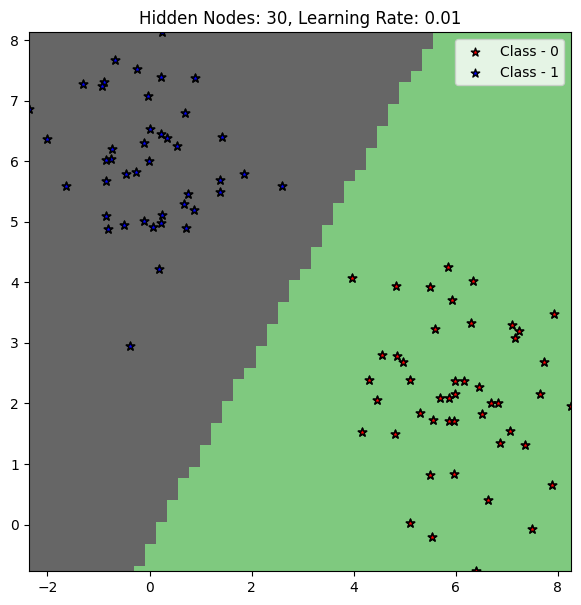

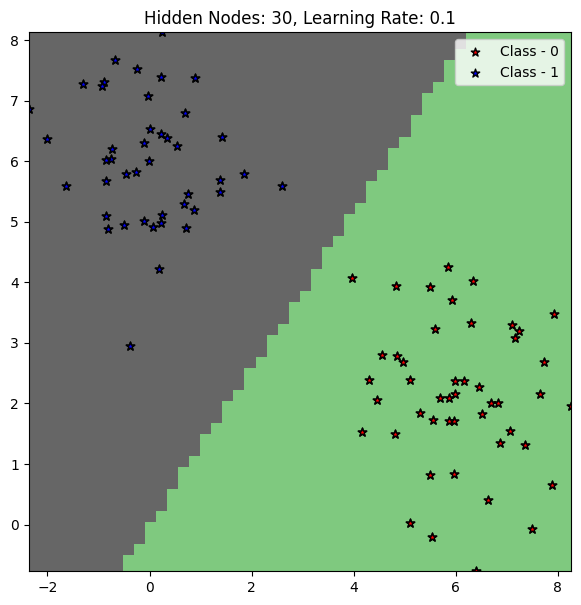

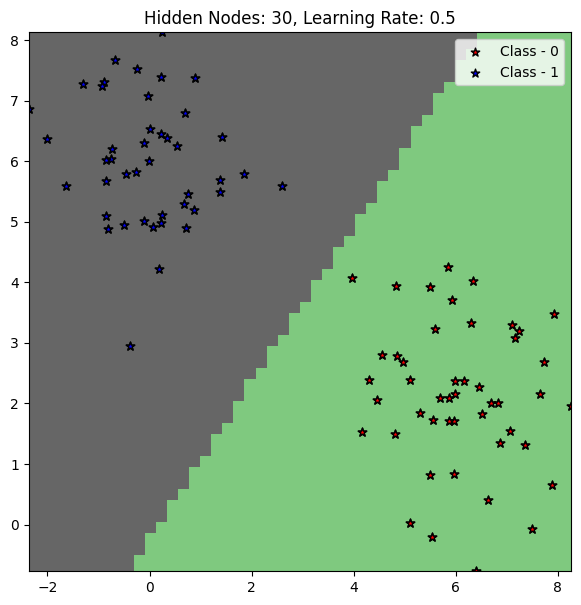

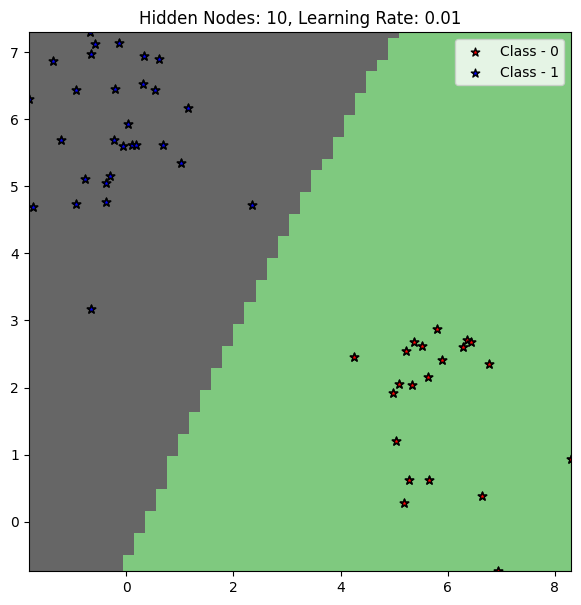

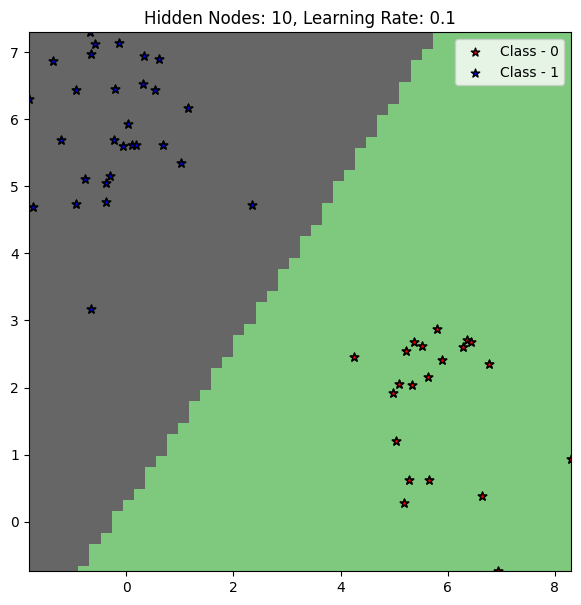

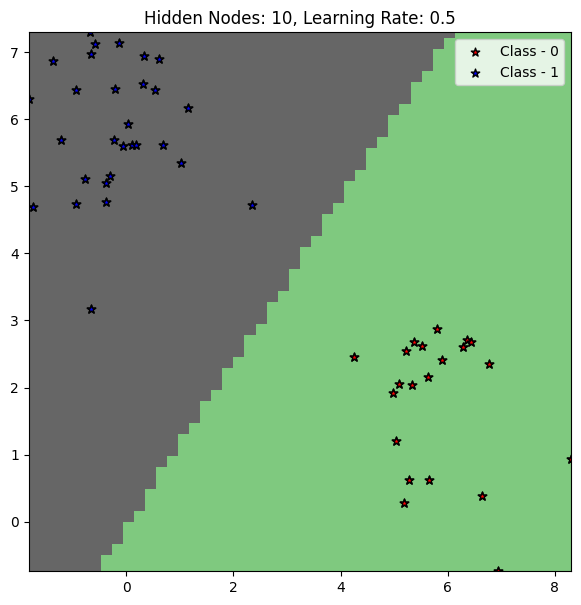

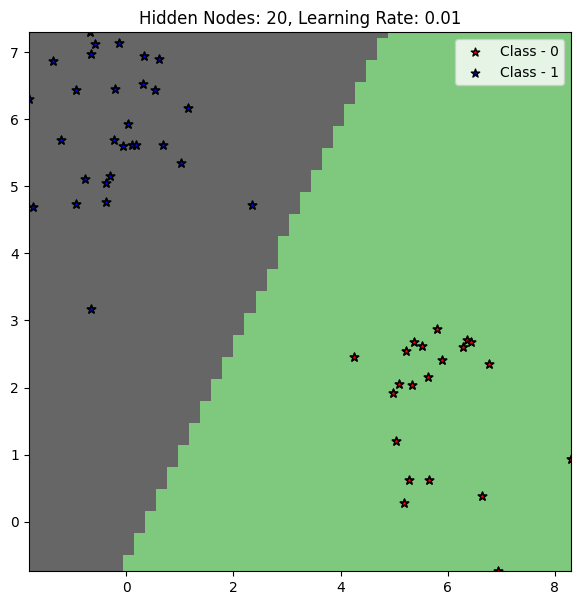

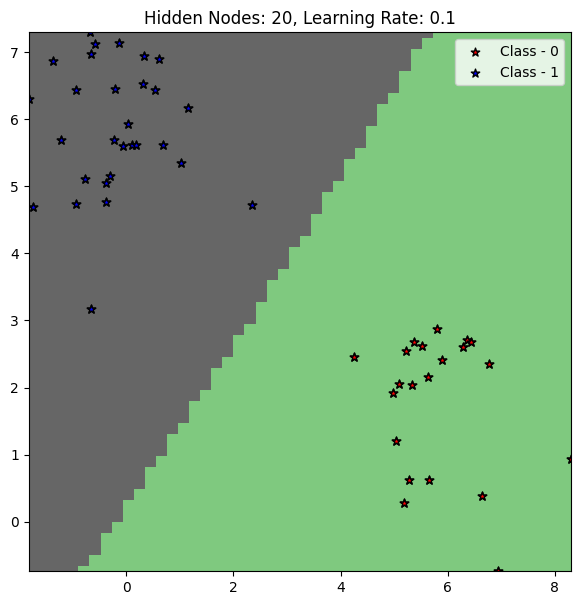

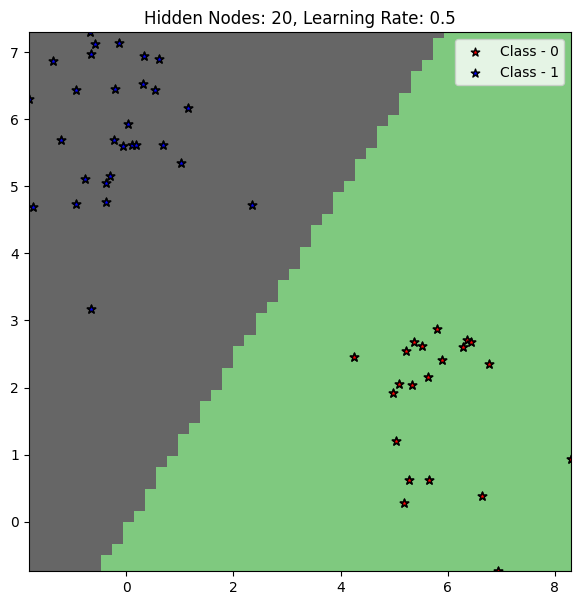

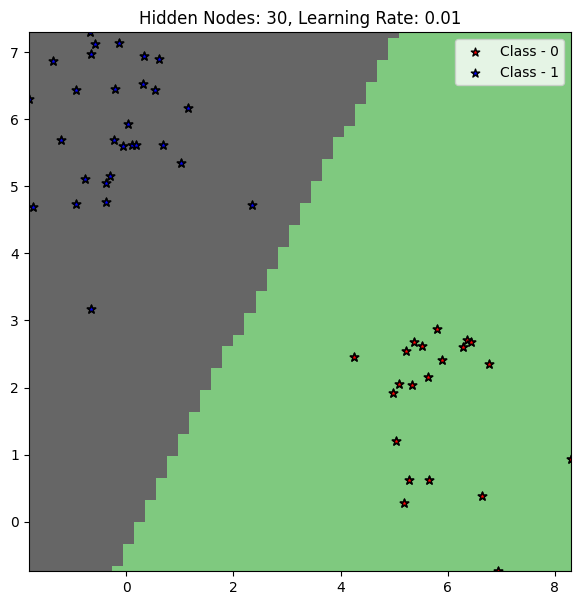

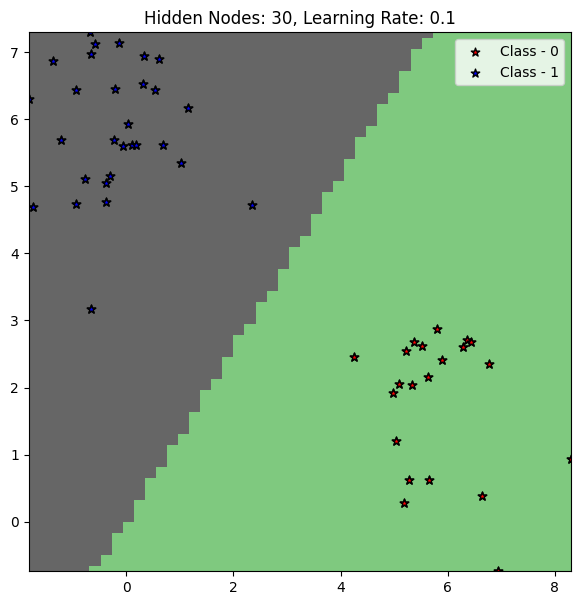

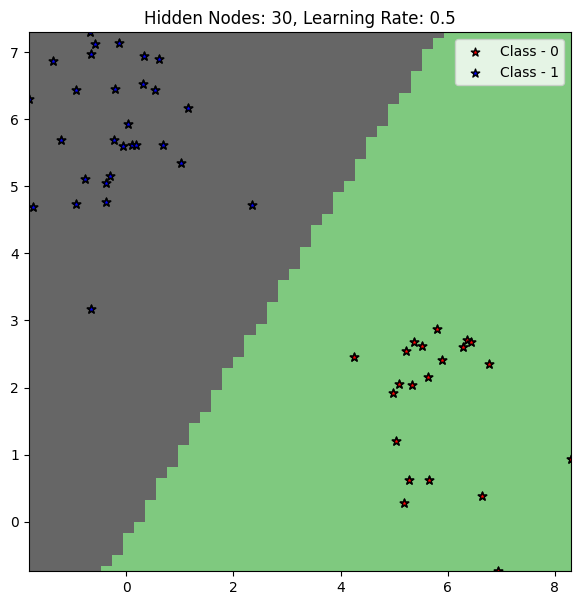

In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf


# Function to build and train the model
def build_and_train_model(train_x, train_y, hidden_layer_nodes, learning_rate):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        # Build the model
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden_layer_nodes, activation='sigmoid', input_shape=(2,)),
            tf.keras.layers.Dense(2, activation='softmax')
        ])

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(train_x, train_y, epochs=50, batch_size=32, verbose=0)

    return model, history

# Function to calculate classification accuracy and confusion matrix
def evaluate_model(model, x, y):
    # Predictions
    y_pred = np.argmax(model.predict(x, verbose=0), axis=1)

    # Classification accuracy
    accuracy = np.mean(y_pred == y)*100

    return accuracy, y_pred

def confusion_matrix(y_true, y_pred, accuracy, labels=None):
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    num_labels = len(labels)
    cm = np.zeros((num_labels + 1, num_labels + 1), float)
    label_to_index = {label: i for i, label in enumerate(labels)}
    true_positives = np.zeros(num_labels)
    pred_positives = np.zeros(num_labels)
    total_samples = len(y_true)
    for true, pred in zip(y_true, y_pred):
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]
        cm[true_index, pred_index] += 1
        true_positives[true_index] += 1 if true == pred else 0
        pred_positives[pred_index] += 1 if true == pred else 0
    cm = cm.T
    accuracy = np.sum(np.diag(cm)) / total_samples
    cm[-1, :-1] = (true_positives / np.sum(cm[:-1, :-1], axis=1)) * 100
    cm[:-1, -1] = (pred_positives / np.sum(cm[:-1, :-1], axis=0)) * 100
    cm[-1, -1] = accuracy * 100
    return cm

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, accuracy, title):
    cm = confusion_matrix(y_true, y_pred, accuracy)
    cm_backup = confusion_matrix(y_true, y_pred, accuracy)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 or j == cm.shape[1] - 1:
                cm[i, j] = 0.0
    number_of_classes = len(np.unique(y_true))
    plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Pastel1_r)
    cm = cm_backup
    plt.title(title, fontsize=16, weight='bold')
    plt.colorbar()
    labels = []
    for i in np.unique(y_true):
        label = "Class " + str(i)
        labels.append(label)
    plt.xticks(range(len(np.unique(y_true))), labels=labels)
    plt.yticks(range(len(np.unique(y_true))), labels=labels)
    plt.xlabel("True Label")
    plt.ylabel("Predicted Label")

    cm_except_last_row_col = cm[:-1, :-1]
    cm_row_sum = np.sum(cm_except_last_row_col, axis=1)
    cm_col_sum = np.sum(cm_except_last_row_col, axis=0)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        row_sum = 0
        for j in range(cm.shape[1]):
            if i == cm.shape[0] - 1 and j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(y_true.size, "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif j == cm.shape[1] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_row_sum[i], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            elif i == cm.shape[0] - 1:
                plt.text(
                    j,
                    i - 0.15,
                    format(cm_col_sum[j], ".2f"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i,
                    format(cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="green",
                )
                plt.text(
                    j,
                    i + 0.15,
                    format(100 - cm[i, j], ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="red",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)
            else:
                percent = (cm[i, j] / y_true.size) * 100
                plt.text(
                    j,
                    i - 0.07,
                    format(int(cm[i, j]), "d"),
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="black",
                )
                plt.text(
                    j,
                    i + 0.07,
                    format(percent, ".2f") + "%",
                    ha="center",
                    va="center",
                    fontweight="bold",
                    color="blue",
                )
                rect = plt.Rectangle(
                    (j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor="grey", linewidth=2
                )
                plt.gca().add_patch(rect)

    plt.grid(False)
    plt.show()

def plot_decision_boundary(models, x, y):

    for i, (hidden_layer_nodes, learning_rate) in enumerate(models.keys()):
        N = 50
        model = models[(hidden_layer_nodes, learning_rate)]

        # Create a meshgrid to plot decision regions
        x_min, x_max = x[:, 0].min(), x[:, 0].max()
        y_min, y_max = x[:, 1].min(), x[:, 1].max()
        x_range = np.linspace(x_min, x_max, N)
        y_range = np.linspace(y_min, y_max, N)
        xx, yy = np.meshgrid(x_range, y_range)

        Z = np.argmax(model.predict(np.c_[xx.ravel(), yy.ravel()], verbose=0), axis=1)
        Z = Z.reshape(xx.shape)

        # Plot decision regions
        classes = np.unique(y)
        number_of_classes = len(classes)
        plt.figure(figsize=(number_of_classes + 5, number_of_classes + 5))
        plt.pcolormesh(xx, yy, Z, cmap='Accent')
        for class_label in classes:
            # Filter data points based on the current label
            x_label = x[y == class_label]
            # Plot only once with the label
            if class_label == classes[0]:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=40, label='Class - '+str(int(class_label)))
                # plt.legend()
            else:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=40)
            if class_label == classes[1]:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='blue', edgecolors="black", marker="*", s=40, label='Class - '+str(int(class_label)))
                # plt.legend()
            else:
                plt.scatter(x_label[:, 0], x_label[:, 1], c='red', edgecolors="black", marker="*", s=40)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.legend()

        # plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        # plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
        plt.title(f"Hidden Nodes: {hidden_layer_nodes}, Learning Rate: {learning_rate}")
        plt.show()

def read_dataset_1(current_directory, folder_number):
    # classification_dataset_1_path=current_directory+ "/Datasets_for_A1/Classification/Dataset 1/" + folder_number + "/"
    classification_dataset_1_path = (
        "/home/dipendu/programs/mtech_2023/ml/ass2/Datasets_for_A1/Classification/Dataset 1/"
        + folder_number
        + "/"
    )

    classification_dataset_1_Train = (
        classification_dataset_1_path + "Train-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Train)
    data = df.to_numpy()
    train_x = data[:, 1:3]
    train_y = data[:, 3]

    classification_dataset_1_Validation = (
        classification_dataset_1_path + "Val-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Validation)
    data = df.to_numpy()
    val_x = data[:, 1:3]
    val_y = data[:, 3]

    classification_dataset_1_Test = (
        classification_dataset_1_path + "Test-" + folder_number + ".csv"
    )
    df = pd.read_csv(classification_dataset_1_Test)
    data = df.to_numpy()
    test_x = data[:, 1:3]
    test_y = data[:, 3]

    return train_x, train_y, val_x, val_y, test_x, test_y

def apply_MLFFNN(train_x, train_y, val_x, val_y, test_x, test_y):

    # Define hyperparameters
    hidden_layer_nodes_list = [10, 20, 30]  # Different number of nodes in the hidden layer
    learning_rates = [0.01, 0.1, 0.5]  # Different learning rates

    # Dictionary to store results
    results = {}
    models = {}
    histories = {}
    # Loop over different hyperparameters
    for hidden_layer_nodes in hidden_layer_nodes_list:
        for learning_rate in learning_rates:
            # Build and train the model
            model, history = build_and_train_model(train_x, train_y, hidden_layer_nodes, learning_rate)
            models[(hidden_layer_nodes, learning_rate)] = model
            histories[(hidden_layer_nodes, learning_rate)] = history

            # Evaluate the model on training data
            train_accuracy, train_y_pred = evaluate_model(model, train_x, train_y)

            # Evaluate the model on validation data
            val_accuracy, val_y_pred = evaluate_model(model, val_x, val_y)

            # Evaluate the model on test data
            test_accuracy, test_y_pred = evaluate_model(model, test_x, test_y)

            # Store results
            results[(hidden_layer_nodes, learning_rate)] = {
                'train_accuracy': train_accuracy,
                'val_accuracy': val_accuracy,
                'test_accuracy': test_accuracy,
                'train_y_pred': train_y_pred,
                'val_y_pred': val_y_pred,
                'test_y_pred': test_y_pred
            }

    # Print the table of classification accuracies
    print("Classification Accuracies:")
    print("{:<15} {:<15} {:<15} {:<15} {:<15}".format("Hidden Nodes", "Learning Rate", "Train Accuracy(%)", "Validation Accuracy(%)", "Test Accuracy(%)"))
    for (hidden_layer_nodes, learning_rate), result in results.items():
        print("{:<15} {:<15} {:<15.2f} {:<19.2f} {:<15.2f}".format(hidden_layer_nodes, learning_rate, result['train_accuracy'], result['val_accuracy'], result['test_accuracy']))


    # Plot confusion matrices
    for i, (hidden_layer_nodes, learning_rate) in enumerate(results.keys()):
        plot_confusion_matrix(train_y, results[(hidden_layer_nodes, learning_rate)]['train_y_pred'], results[(hidden_layer_nodes, learning_rate)]['train_accuracy'], title=f"Train (Nodes={hidden_layer_nodes}, LR={learning_rate})")

    for i, (hidden_layer_nodes, learning_rate) in enumerate(results.keys()):
        plot_confusion_matrix(val_y, results[(hidden_layer_nodes, learning_rate)]['val_y_pred'], results[(hidden_layer_nodes, learning_rate)]['val_accuracy'], title=f"Validation (Nodes={hidden_layer_nodes}, LR={learning_rate})")

    for i, (hidden_layer_nodes, learning_rate) in enumerate(results.keys()):
        plot_confusion_matrix(test_y, results[(hidden_layer_nodes, learning_rate)]['test_y_pred'], results[(hidden_layer_nodes, learning_rate)]['test_accuracy'], title=f"Test (Nodes={hidden_layer_nodes}, LR={learning_rate})")


    plot_decision_boundary(models, train_x, train_y)
    plot_decision_boundary(models, val_x, val_y)
    plot_decision_boundary(models, test_x, test_y)

    

def main():
    folder_number = "9"
    current_directory = os.getcwd()

    train_x, train_y, val_x, val_y, test_x, test_y = read_dataset_1(
        current_directory, folder_number
    )
    apply_MLFFNN(train_x, train_y, val_x, val_y, test_x, test_y)

    

if __name__ == "__main__":
    main()


Classification Accuracies:
Hidden Nodes    Learning Rate   Train Accuracy  Validation Accuracy
10              0.01            0.58            0.44            0.58           
10              0.001           0.51            0.42            0.47           
10              0.0001          0.31            0.40            0.38           
20              0.01            0.58            0.47            0.60           
20              0.001           0.50            0.42            0.53           
20              0.0001          0.35            0.24            0.36           
30              0.01            0.62            0.49            0.60           
30              0.001           0.52            0.47            0.56           
30              0.0001          0.29            0.20            0.31           
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/home/dipendu/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


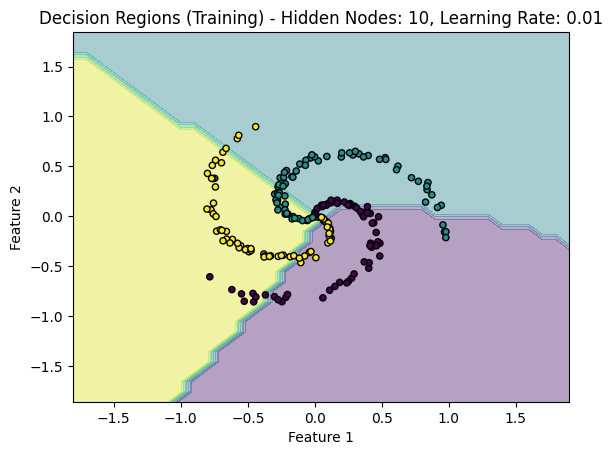

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step


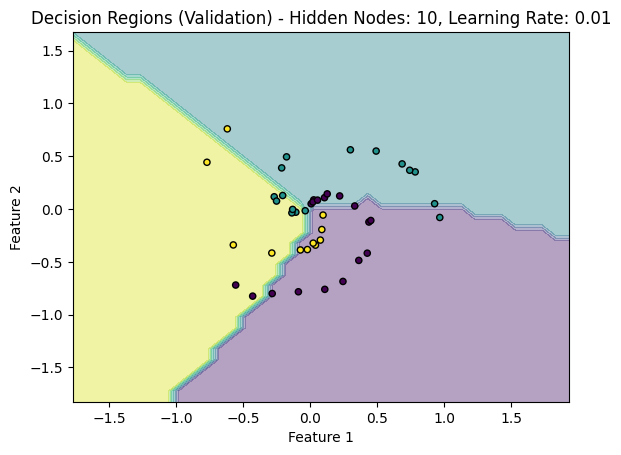

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step


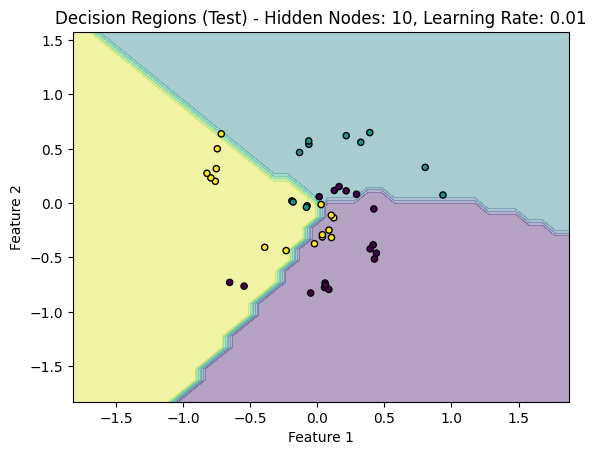

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


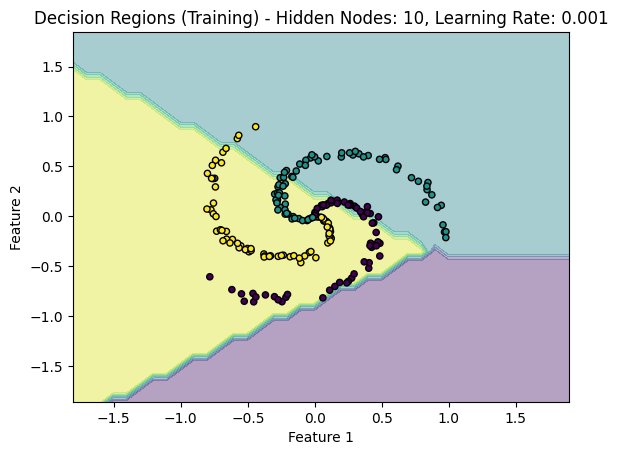

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


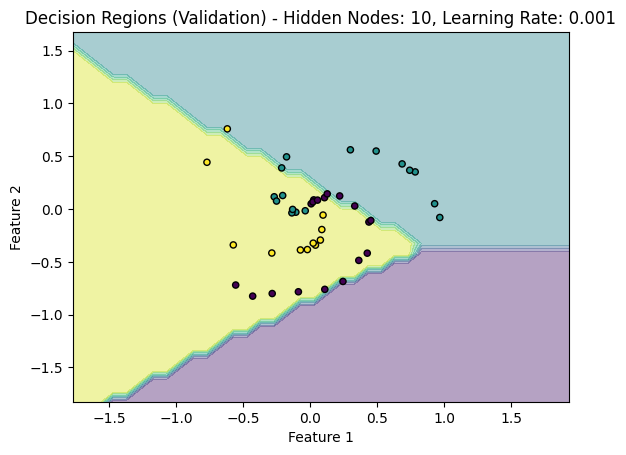

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


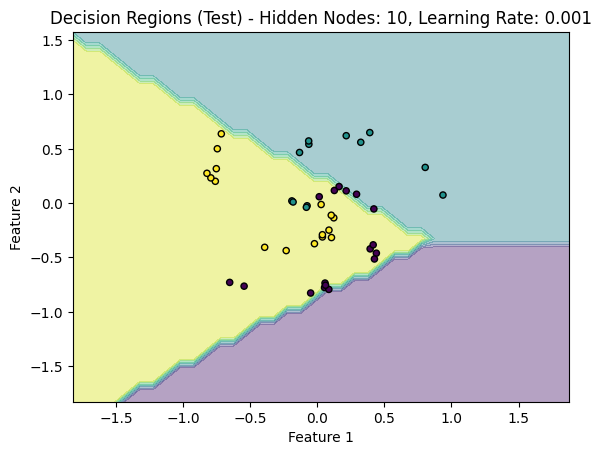

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


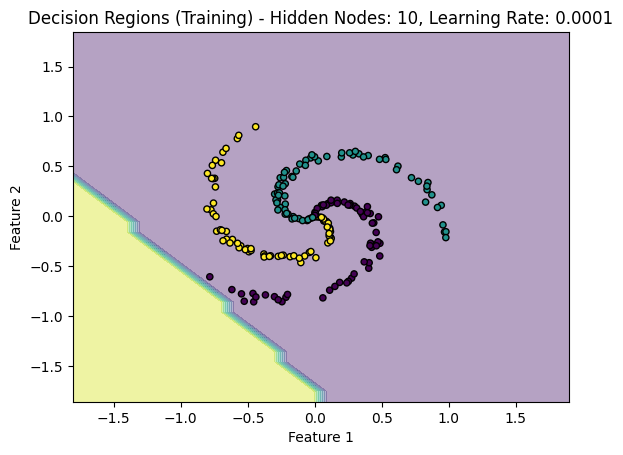

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step


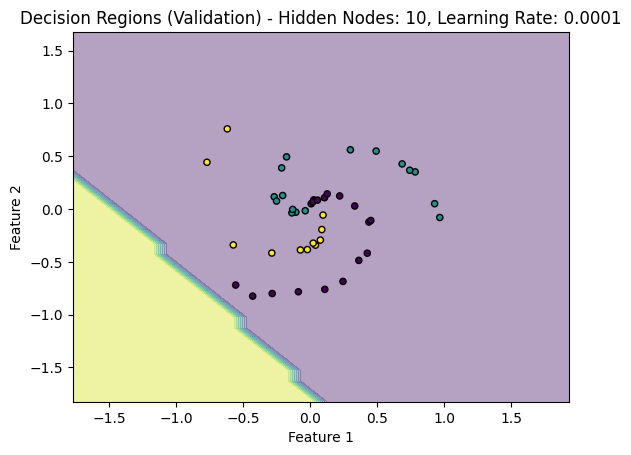

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step


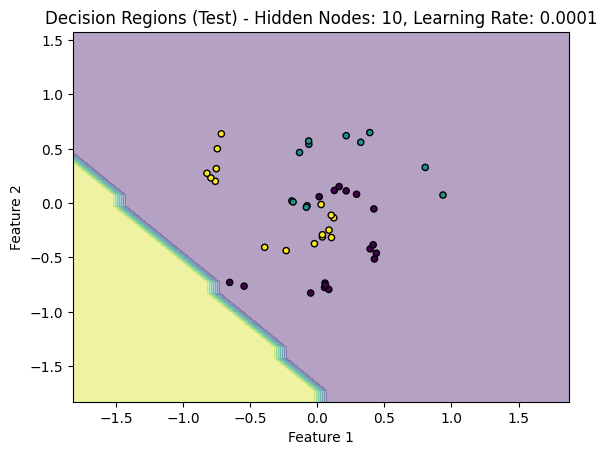

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


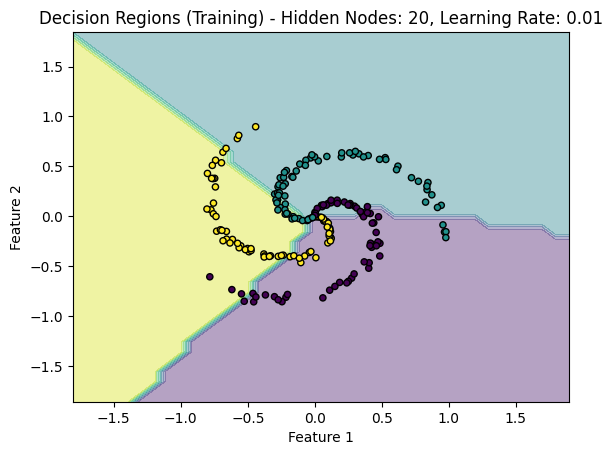

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step


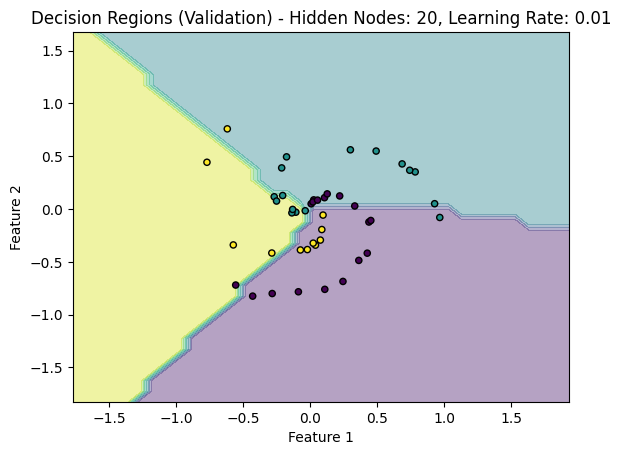

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


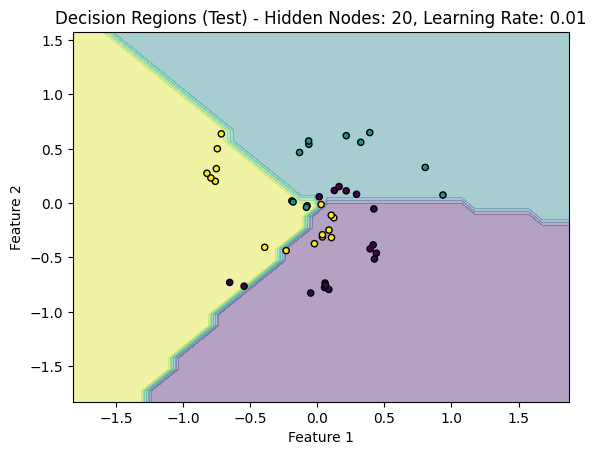

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


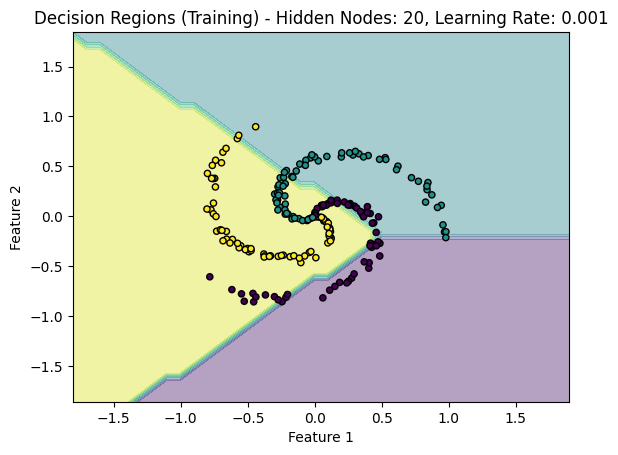

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


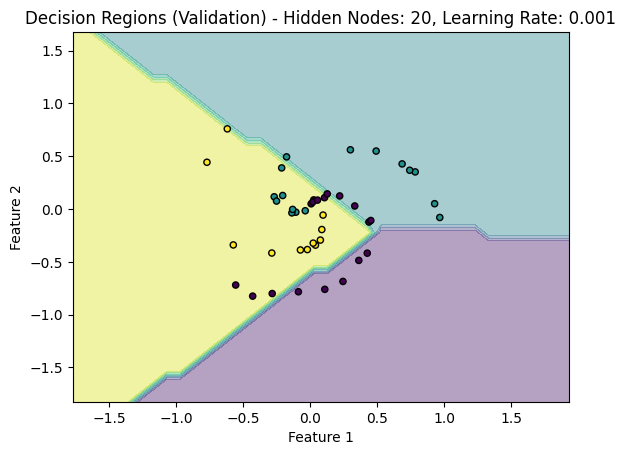

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step


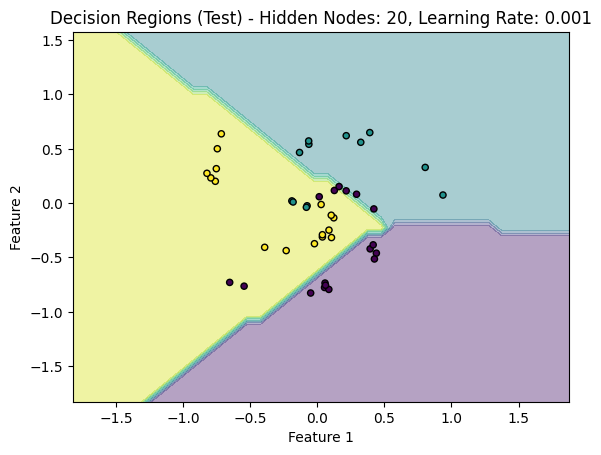

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


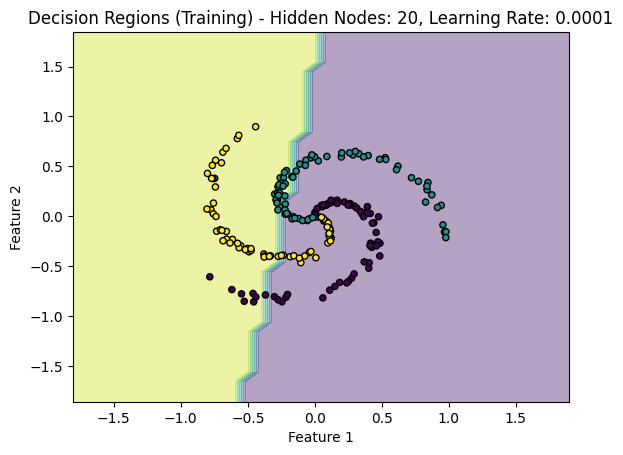

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step


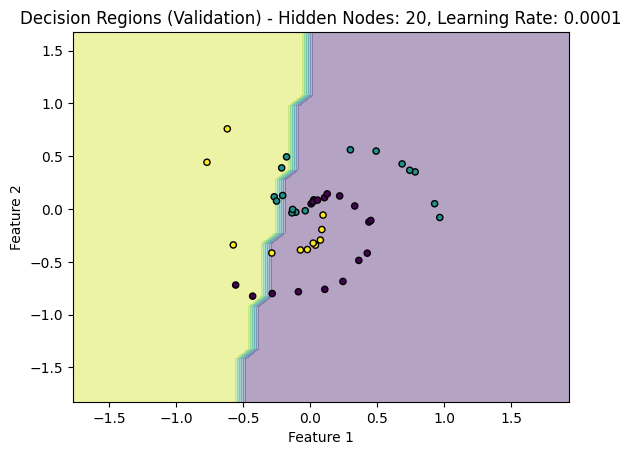

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


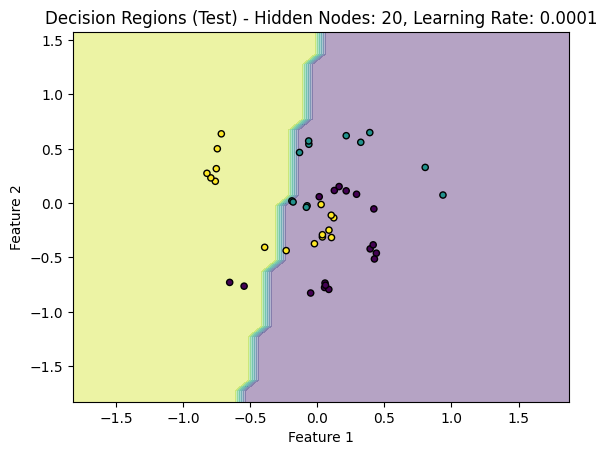

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


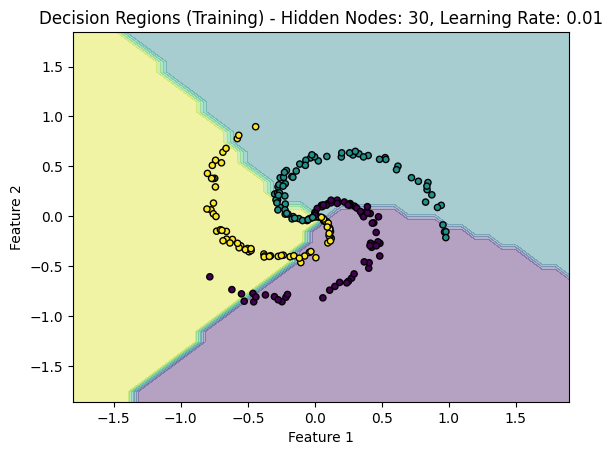

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step


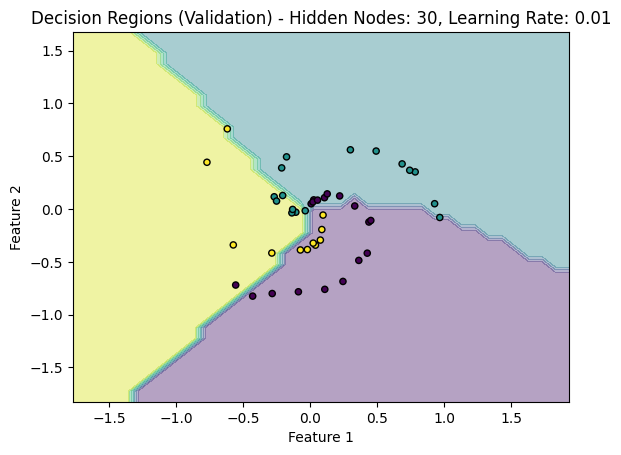

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


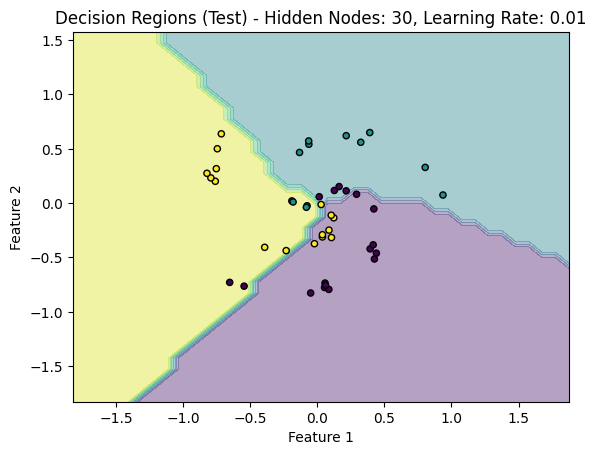

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


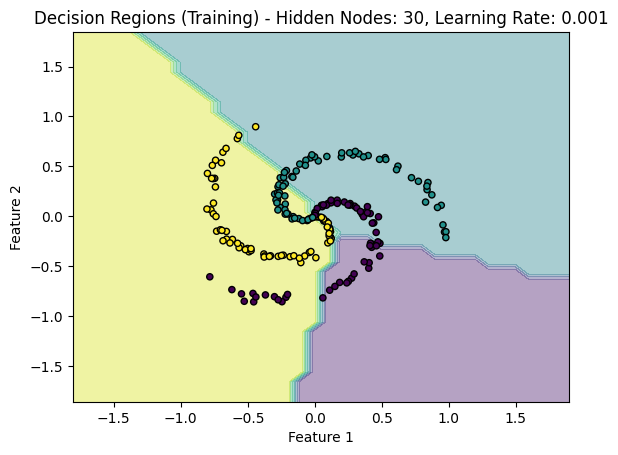

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step


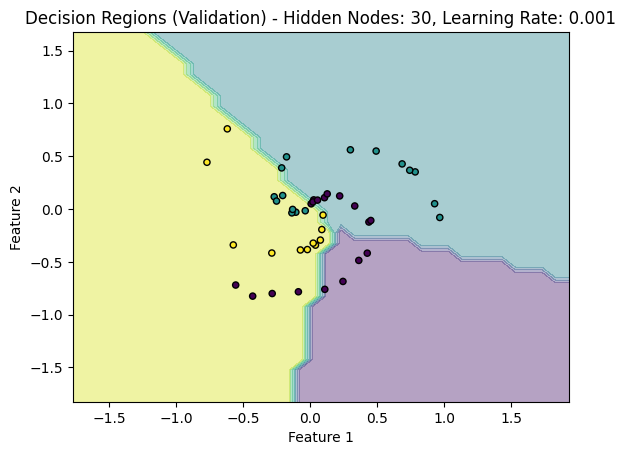

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


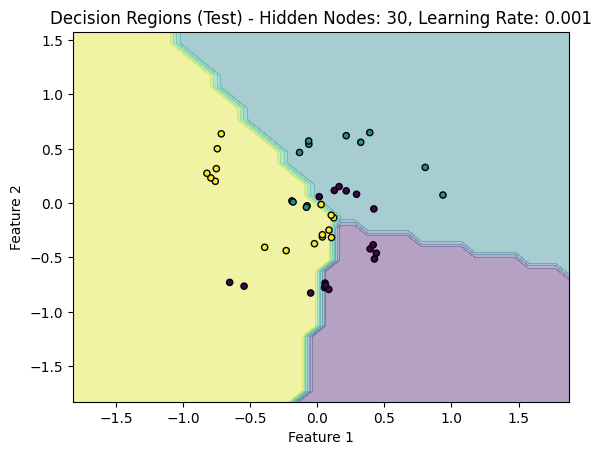

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


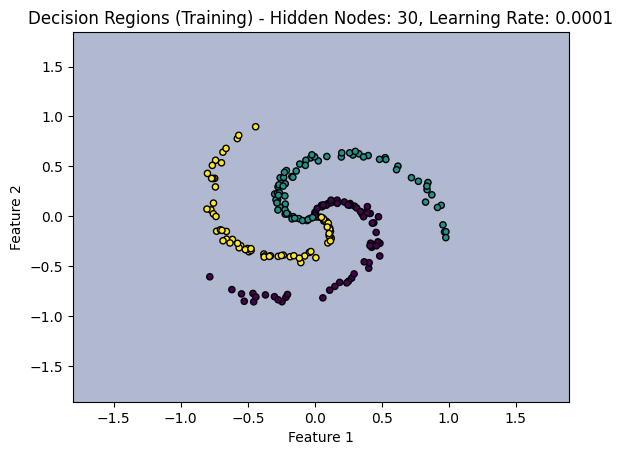

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


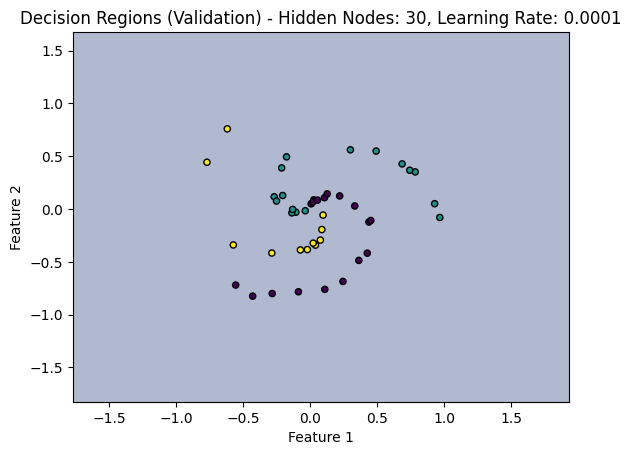

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step


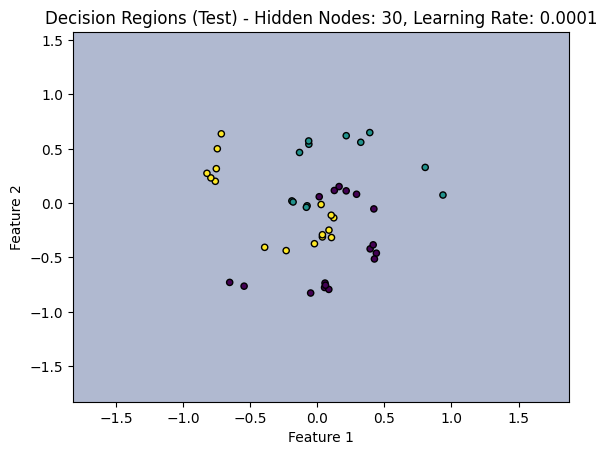

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import tensorflow as tf

# X, y = make_classification(n_samples=1000, n_features=2, n_classes=2, n_informative=2, 
#                            n_redundant=0, n_clusters_per_class=1, random_state=42)

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# import numpy as np

def generate_spiral_data(n_samples, n_classes=2, noise=0.1):
    X = np.zeros((n_samples * n_classes, 2))
    y = np.zeros(n_samples * n_classes, dtype='uint8')
    for class_idx in range(n_classes):
        ix = range(n_samples * class_idx, n_samples * (class_idx + 1))
        r = np.linspace(0.0, 1, n_samples)
        t = np.linspace(class_idx * 4, (class_idx + 1) * 4, n_samples) + np.random.randn(n_samples) * noise
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_idx
    return X, y

# Generate spiral data
X, y = generate_spiral_data(n_samples=100, n_classes=3, noise=0.1)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

hidden_layer_nodes = [10, 20, 30]  # Different numbers of nodes in hidden layers
learning_rates = [0.01, 0.001, 0.0001]  # Different learning rates

def create_model(hidden_nodes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(hidden_nodes[0], activation='sigmoid', input_shape=(2,)),
        tf.keras.layers.Dense(hidden_nodes[1], activation='sigmoid'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

results = {}
for nodes in hidden_layer_nodes:
    for lr in learning_rates:
        model = create_model([nodes, nodes])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
        train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
        val_acc = model.evaluate(X_val, y_val, verbose=0)[1]
        test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
        results[(nodes, lr)] = {'train_accuracy': train_acc,
                                'val_accuracy': val_acc,
                                'test_accuracy': test_acc,
                                'history': history}

print("Classification Accuracies:")
print("{:<15} {:<15} {:<15} {:<15}".format("Hidden Nodes", "Learning Rate", "Train Accuracy", "Validation Accuracy", "Test Accuracy"))
for (nodes, lr), result in results.items():
    print("{:<15} {:<15} {:<15.2f} {:<15.2f} {:<15.2f}".format(nodes, lr, result['train_accuracy'], result['val_accuracy'], result['test_accuracy']))

for (nodes, lr), result in results.items():
    model = create_model([nodes, nodes])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, verbose=0)
    y_train_pred = np.argmax(model.predict(X_train), axis=1)
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    y_test_pred = np.argmax(model.predict(X_test), axis=1)
    train_cm = confusion_matrix(y_train, y_train_pred)
    val_cm = confusion_matrix(y_val, y_val_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

# Define a function to plot decision regions
def plot_decision_regions(X, y, model, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

# Plot decision regions for training, validation, and test data
for (nodes, lr), result in results.items():
    model = create_model([nodes, nodes])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=50, verbose=0)
    plot_decision_regions(X_train, y_train, model, title=f"Decision Regions (Training) - Hidden Nodes: {nodes}, Learning Rate: {lr}")
    plot_decision_regions(X_val, y_val, model, title=f"Decision Regions (Validation) - Hidden Nodes: {nodes}, Learning Rate: {lr}")
    plot_decision_regions(X_test, y_test, model, title=f"Decision Regions (Test) - Hidden Nodes: {nodes}, Learning Rate: {lr}")

